In [ ]:
import numpy as np
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from math import *
import queue
import sys
sys.setrecursionlimit(6000)

# Partie 1 : Construction des classes permettant de créer, manipuler et afficher les arbres de G.W

# 1.1
On crée une liste param qui comprend des réels tirés aléatoirement entre 0 et 1. On définit ensuite une loi (que l'on nomme juste loi pour l'instant car il y en a qu'une seule) dépendant de x qui renvoie 0 avec proba (1-x)/2, 1 avec proba x, et 2 avec proba (1-x)/2. Cette loi est toujours d'esperance 1 mais sa variance dépend de x. Dans la suite, on simule la progénie d'un noeud de hauteur h en tirant son nombre d'enfants suivant loi(param[h]).

In [ ]:
param=[]
def param_Filling (n):
    for i in range(n):
        param.append(np.random.random())
param_Filling (10000)
def loi(x):
    y = np.random.random()
    if y<(1-x)/2 :
        return 0
    if y>(1-x)/2 and y<(1+x)/2 :
        return 1
    if y>(1+x)/2 :
        return 2

# 1.2
On crée à présent une classe correspondant à l'arbre de Galton Watson. La fonction simulate crée l'arbre de Galton Watson, on borne la hauteur par le paramètre n pour être sur que l'on ne va pas se lancer dans la simulation d'un arbre de Galton infini et donc faire tourner notre code indéfiniment. Les fonctions Children_Number_list renvoie la liste du nombre d'enfants par ordre lexicographique, même principe pour la hauteur, la marche aléatoire de Lukasiewicz ect.

In [ ]:
class Galton_Watson():
    def __init__(self, children, height, name):
        self.children=children
        self.height=height
        self.name=name
    def simulate(self,n): 
        if n<=0 :
            number_children=0        
        else :   
            number_children = loi(param[self.height])
        
        if (number_children>0):
            for i in range (number_children):
                self.children.append(Galton_Watson([],self.height+1,self.name+str(i+1)))
                self.children[-1].simulate(n-1)
    def simulate_iterative(self,n):
        q=queue.Queue()
        l=[[self]]
        number_children = loi(param[0])
        for i in range (n):
            l.append([])
            for each in l[i] :
                number_children = loi(param[i+1])
                if number_children > 0 :
                    for k in range (number_children):
                        gal=Galton([],i+1,each.name+str(k))
                        l[i+1].append(gal)
                        each.children.append(gal)
            
    def parcours_luka(self):
        print (self.height,self.name)
        if (len(self.children)>0) :
            for each in self.children :
                each.parcours_luka()
                
    def Children_Number_list(self):
        l=[]
        l.append(len(self.children))
        if (len(self.children)>0) :
            for each in self.children :
                l+=each.Children_Number_list()
        return l
    def Name_list(self):
        l=[]
        l.append(self.name)
        if (len(self.children)>0) :
            for each in self.children :
                l+=each.Name_list()
        return l    
   
    def Height_list(self):
        l=[]
        l.append(self.height)
        if (len(self.children)>0) :
            for each in self.children :
                l+=each.Height_list()
        return l     
    def Luka_list(self):
        s=[0]
        l=self.Children_Number_list()
        for i in l :
            s.append(s[-1]+i-1)
        return s
    def Breadth_Search(self):
        l=[len(self.children)]
        q1=queue.Queue()
        for each in self.children :
            q1.put(each)
        while (q1.empty()==False):
            galt=q1.get()
            l.append(len(galt.children))
            for each in galt.children :
                q1.put(each)
        return l
    def Breadth_Search_List(self):
        s=[0]
        l=self.Breadth_Search()
        for i in l :
            s.append(s[-1]+i-1)
        return s
        
    def __repr__(self):
        return self.name

# 1.3
Cette cellule ne me sert juste à afficher l'arbre de Galton-Watson proprement, on attribue aux noeuds de chaque génération une position bi dimensionnelle cherchée récursivement pour être le plus loin des autres noeuds. ces positions seront prises en argument dans l'affichage de l'arbre plus loin dans le code. Cela me permet d'afficher des arbres de Galton Watson de taille importante tout en conservant une grande lisibilité de l'arbre.

In [ ]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0: 
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos

def hierarchy_pos_2(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

# 1.4
Cette classe me sert à afficher les arbres de Galton Watson, de cette manière je peux vérifier directement les différentes fonctions associées à mon arbre de Galton Watson, notamment la marche aléatoire de Lukasiewicz qui est l'objet de ce code. J'utilise la librairie networkx, très pratique pour les affichages de graphe. On peut enlever les labels des graphes en mettant "with_labels=0" dans la fonction draw_graph_tree.

In [ ]:
class Graph ():
    def __init__(self,number) :
        self.graph=nx.Graph()
        self.number=number
    def add_nodes(self,gal):
        self.graph.add_node(gal)
        for each in gal.children :
            self.add_nodes(each)
    def add_edges(self,gal):
        for each in gal.children :
            self.graph.add_edge(gal,each)
            self.add_edges(each)
            
    
    
    def draw_graph_tree (self,root):
        nx.draw_networkx(self.graph, pos=hierarchy_pos_2(self.graph,root),node_size=45, with_labels=1, font_size=14)
    def draw_graph_spring(self):
        nx.draw_networkx(self.graph, pos=nx.spring_layout(self.graph), node_size=45, with_labels=False)
    def draw_graph_planar(self):
        nx.draw_networkx(self.graph, pos=nx.planar_layout(self.graph), node_size=45, with_labels=1)

# 1.5
J'affiche 10 arbres de Galton Watson ainsi que les différentes listes (hauteur, noms des noeuds, nombre d'enfants, marche de luka) afin de vérifier qu'il n'y a pas de bugs.

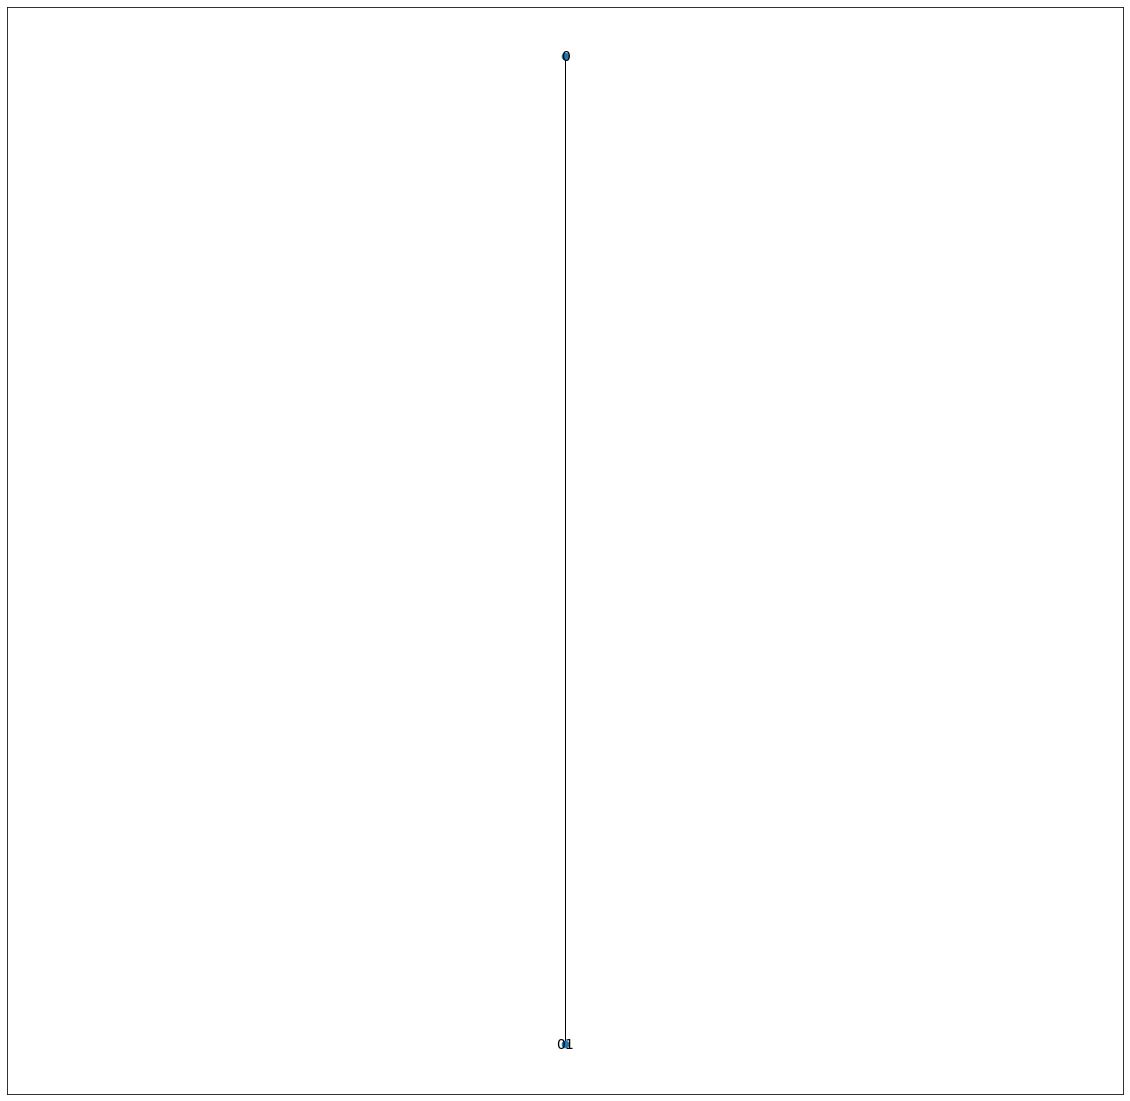

The list of heights is :
[0, 1]
------------------------------------------
The list of names is :
['0', '01']
------------------------------------------
The list of number of children is :
[1, 0]
------------------------------------------
The list of Luka points is :
[0, 0, -1]
------------------------------------------
The list of Breadth First Search points is :
[1, 0]


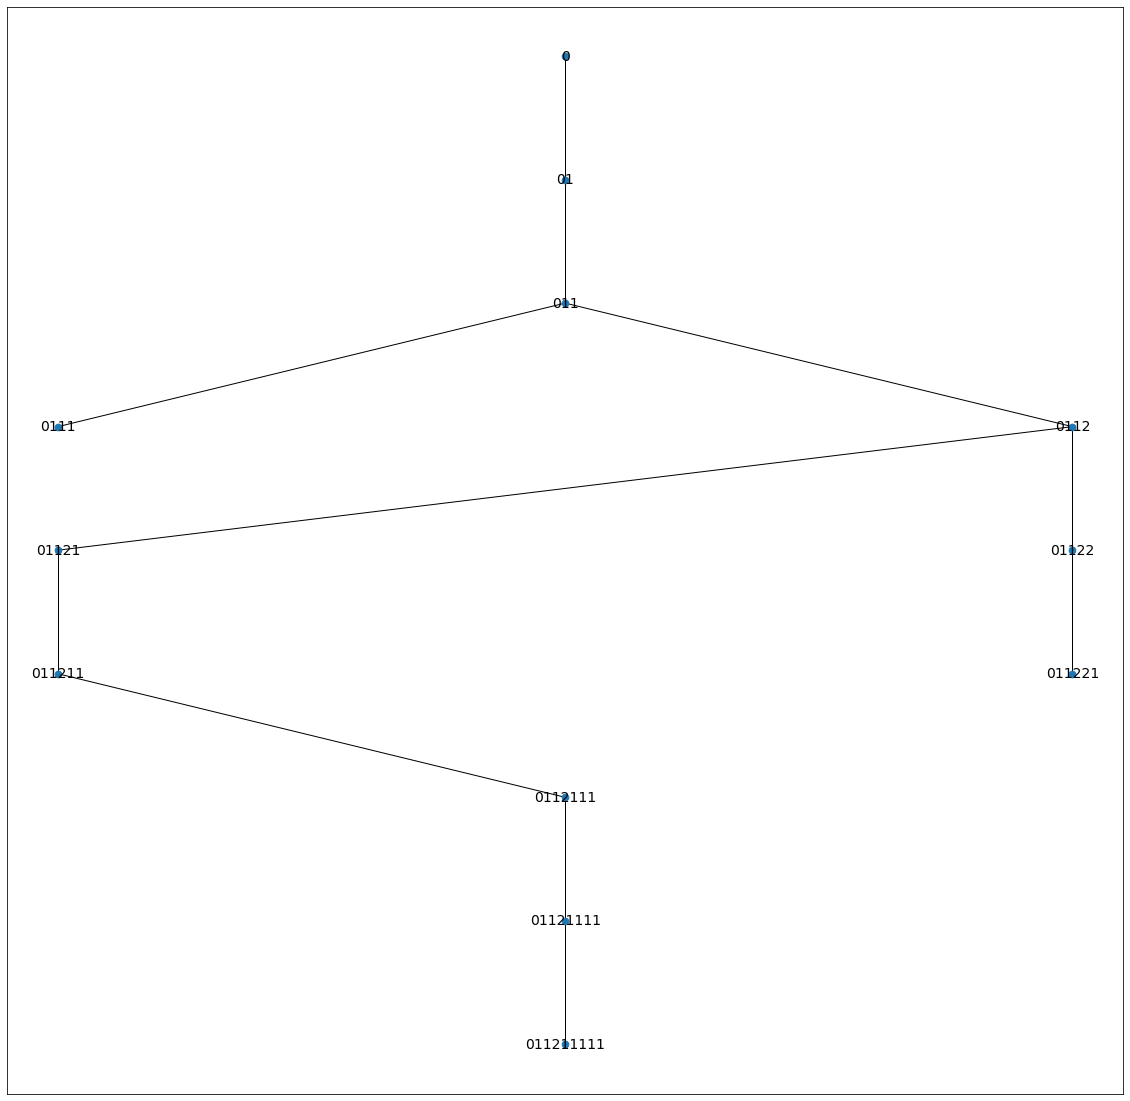

The list of heights is :
[0, 1, 2, 3, 3, 4, 5, 6, 7, 8, 4, 5]
------------------------------------------
The list of names is :
['0', '01', '011', '0111', '0112', '01121', '011211', '0112111', '01121111', '011211111', '01122', '011221']
------------------------------------------
The list of number of children is :
[1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 0]
------------------------------------------
The list of Luka points is :
[0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, -1]
------------------------------------------
The list of Breadth First Search points is :
[1, 1, 2, 0, 2, 1, 1, 1, 0, 1, 1, 0]


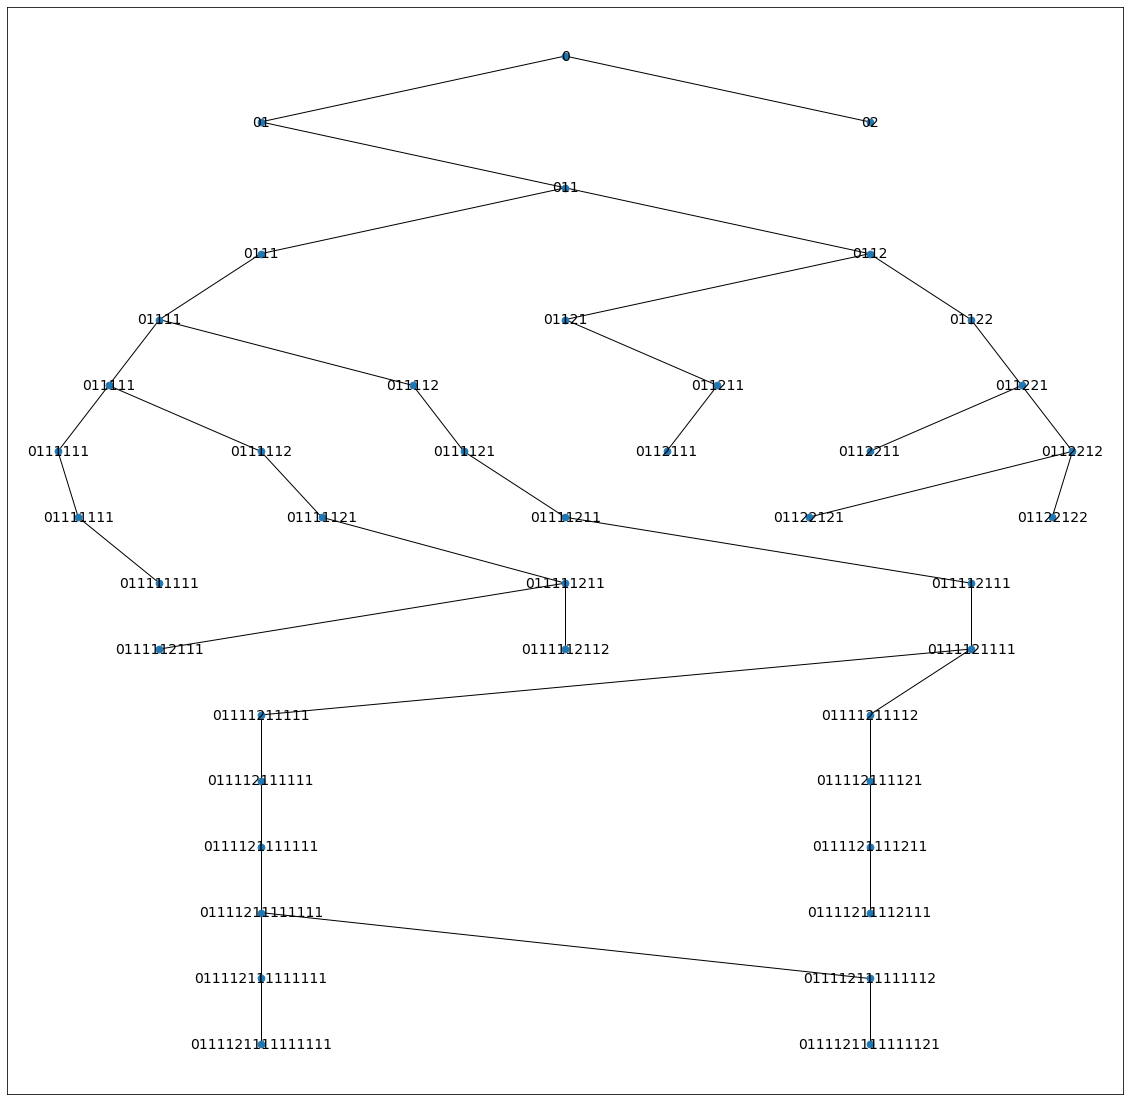

The list of heights is :
[0, 1, 2, 3, 4, 5, 6, 7, 8, 6, 7, 8, 9, 9, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 14, 15, 10, 11, 12, 13, 3, 4, 5, 6, 4, 5, 6, 6, 7, 7, 1]
------------------------------------------
The list of names is :
['0', '01', '011', '0111', '01111', '011111', '0111111', '01111111', '011111111', '0111112', '01111121', '011111211', '0111112111', '0111112112', '011112', '0111121', '01111211', '011112111', '0111121111', '01111211111', '011112111111', '0111121111111', '01111211111111', '011112111111111', '0111121111111111', '011112111111112', '0111121111111121', '01111211112', '011112111121', '0111121111211', '01111211112111', '0112', '01121', '011211', '0112111', '01122', '011221', '0112211', '0112212', '01122121', '01122122', '02']
------------------------------------------
The list of number of children is :
[2, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 0, 1, 2, 0, 2, 0, 0, 0]
---------------------------------------

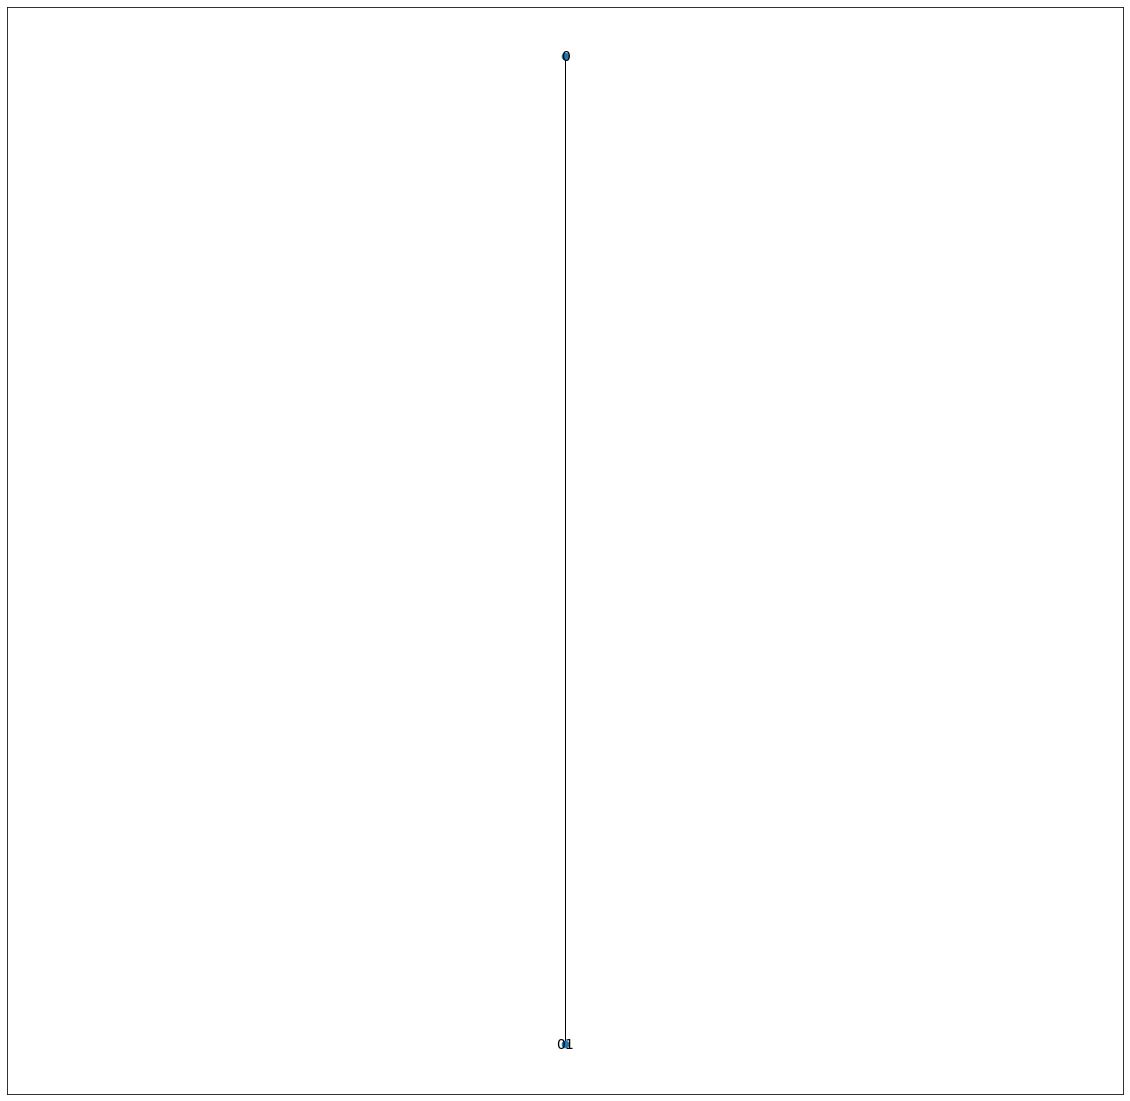

The list of heights is :
[0, 1]
------------------------------------------
The list of names is :
['0', '01']
------------------------------------------
The list of number of children is :
[1, 0]
------------------------------------------
The list of Luka points is :
[0, 0, -1]
------------------------------------------
The list of Breadth First Search points is :
[1, 0]


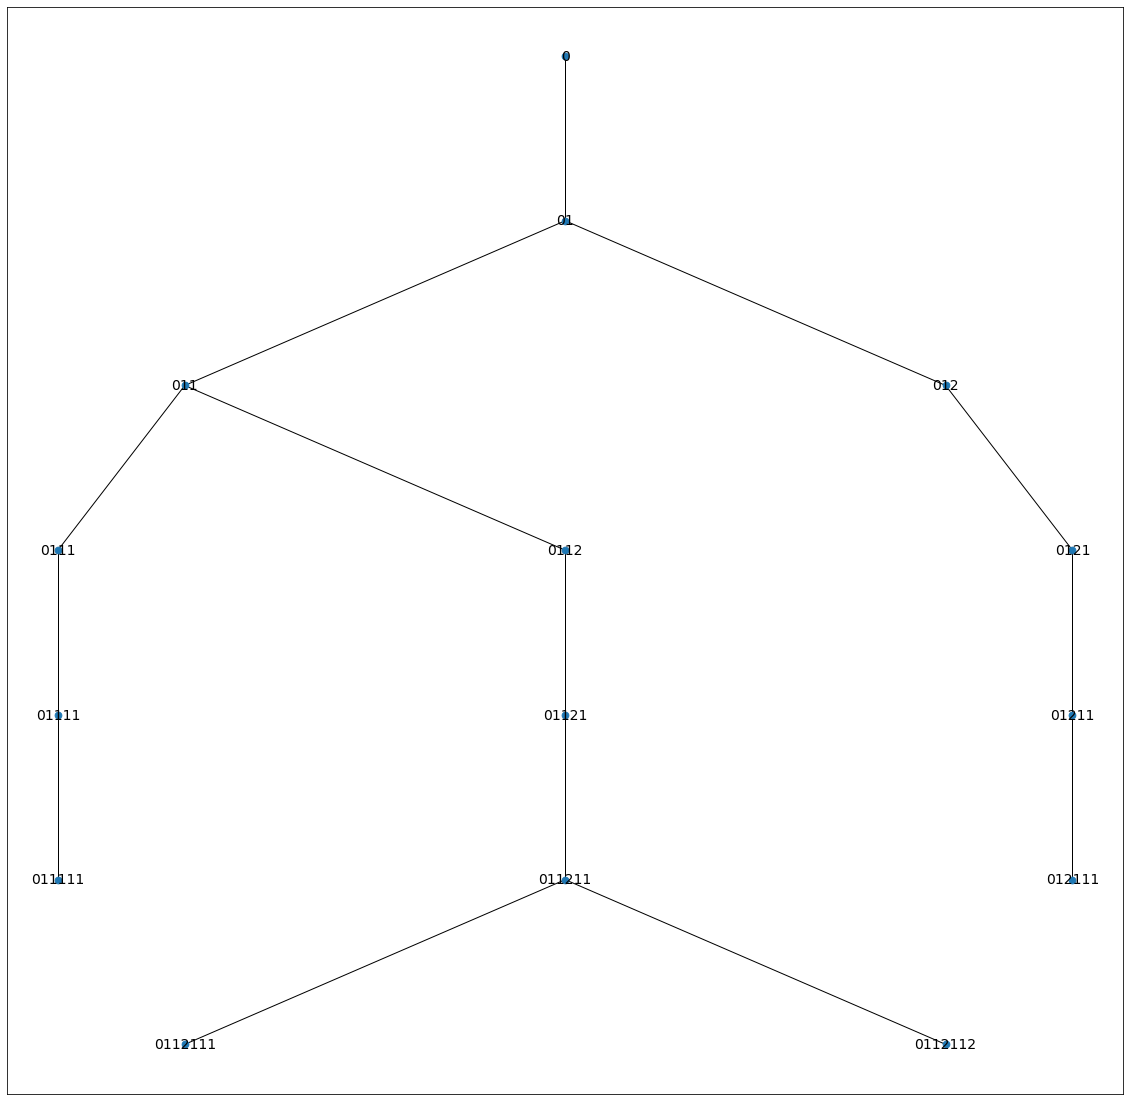

The list of heights is :
[0, 1, 2, 3, 4, 5, 3, 4, 5, 6, 6, 2, 3, 4, 5]
------------------------------------------
The list of names is :
['0', '01', '011', '0111', '01111', '011111', '0112', '01121', '011211', '0112111', '0112112', '012', '0121', '01211', '012111']
------------------------------------------
The list of number of children is :
[1, 2, 2, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1, 0]
------------------------------------------
The list of Luka points is :
[0, 0, 1, 2, 2, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, -1]
------------------------------------------
The list of Breadth First Search points is :
[1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0]
Il y a un seul noeud
--------------------------
The list of heights is :
[0]
------------------------------------------
The list of names is :
['0']
------------------------------------------
The list of number of children is :
[0]
------------------------------------------
The list of Luka points is :
[0, -1]
-----------------------------------------

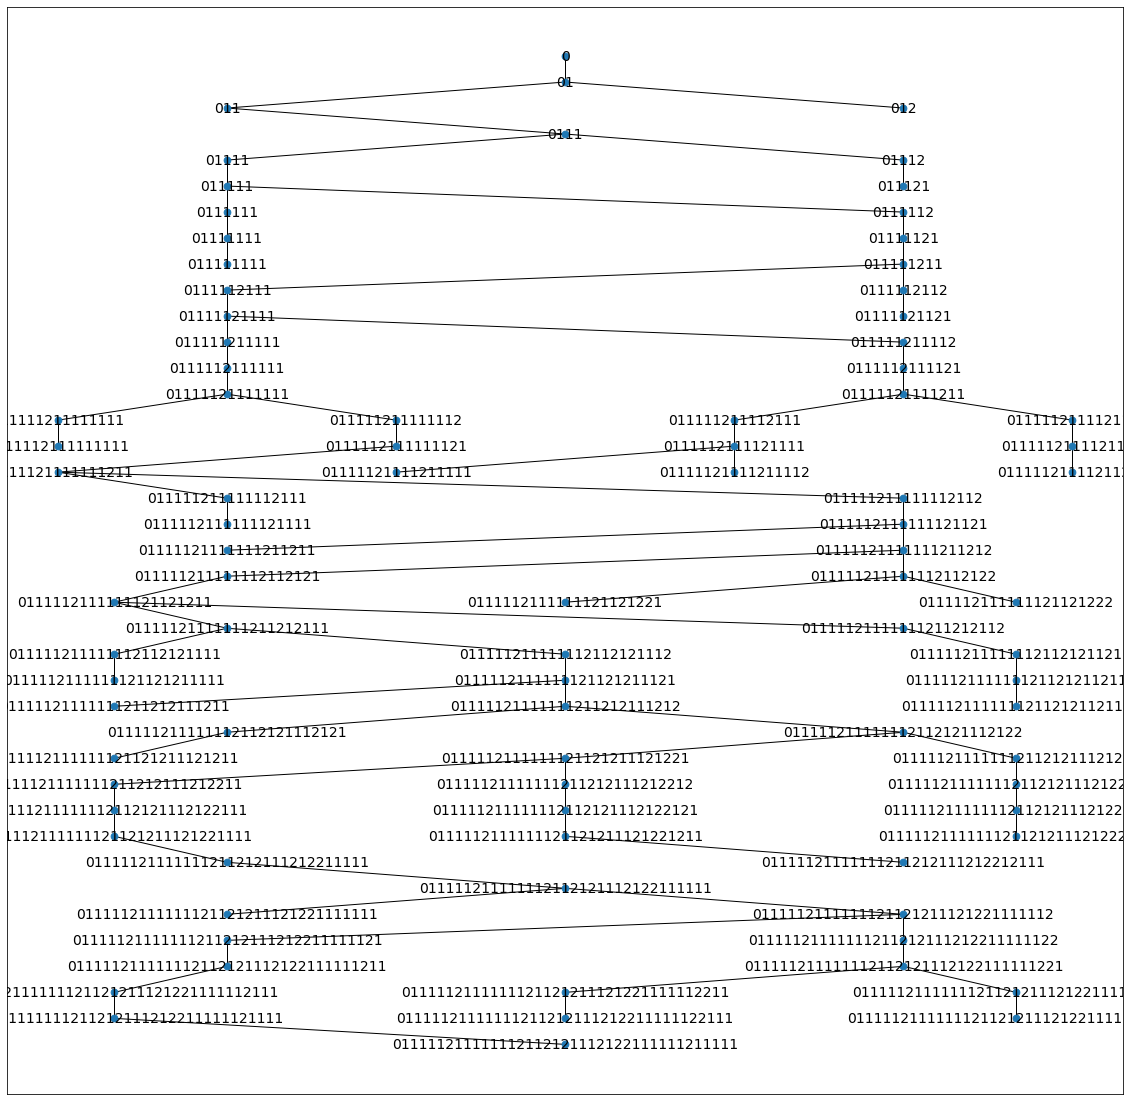

The list of heights is :
[0, 1, 2, 3, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 14, 15, 16, 17, 18, 17, 18, 19, 19, 20, 21, 22, 23, 24, 23, 24, 25, 25, 26, 27, 26, 27, 28, 29, 30, 31, 32, 33, 33, 34, 35, 36, 37, 38, 34, 35, 36, 37, 36, 37, 28, 29, 30, 31, 27, 28, 29, 30, 22, 23, 24, 25, 20, 21, 21, 11, 12, 13, 14, 15, 16, 16, 14, 15, 16, 9, 10, 4, 5, 2]
------------------------------------------
The list of names is :
['0', '01', '011', '0111', '01111', '011111', '0111111', '01111111', '011111111', '0111112', '01111121', '011111211', '0111112111', '01111121111', '011111211111', '0111112111111', '01111121111111', '011111211111111', '0111112111111111', '011111211111112', '0111112111111121', '01111121111111211', '011111211111112111', '0111112111111121111', '011111211111112112', '0111112111111121121', '01111121111111211211', '01111121111111211212', '011111211111112112121', '0111112111111121121211', '01111121111111211212111', '011111211111112112121111', '0111112111111121121211111',

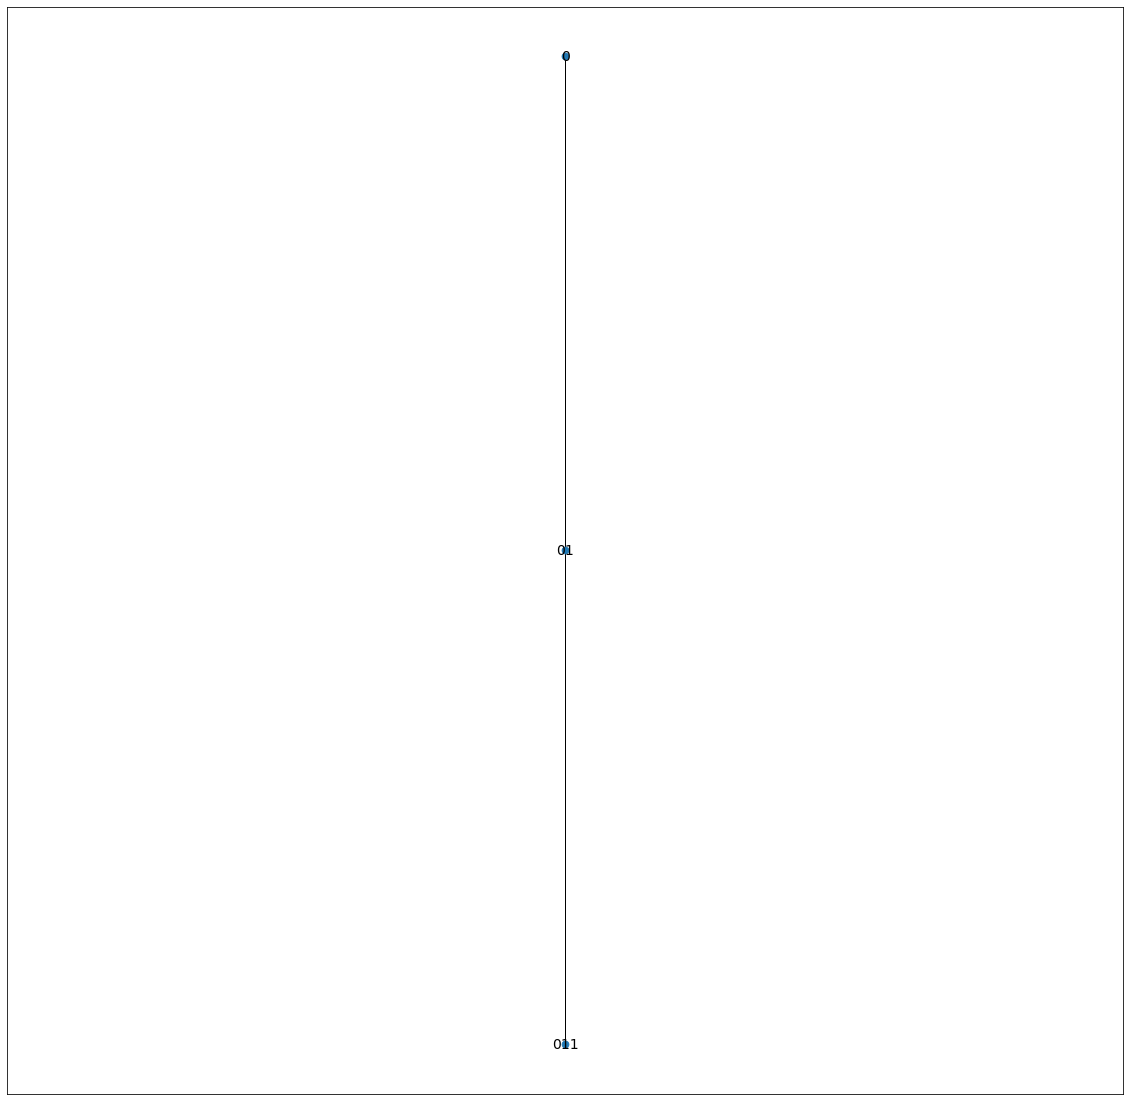

The list of heights is :
[0, 1, 2]
------------------------------------------
The list of names is :
['0', '01', '011']
------------------------------------------
The list of number of children is :
[1, 1, 0]
------------------------------------------
The list of Luka points is :
[0, 0, 0, -1]
------------------------------------------
The list of Breadth First Search points is :
[1, 1, 0]


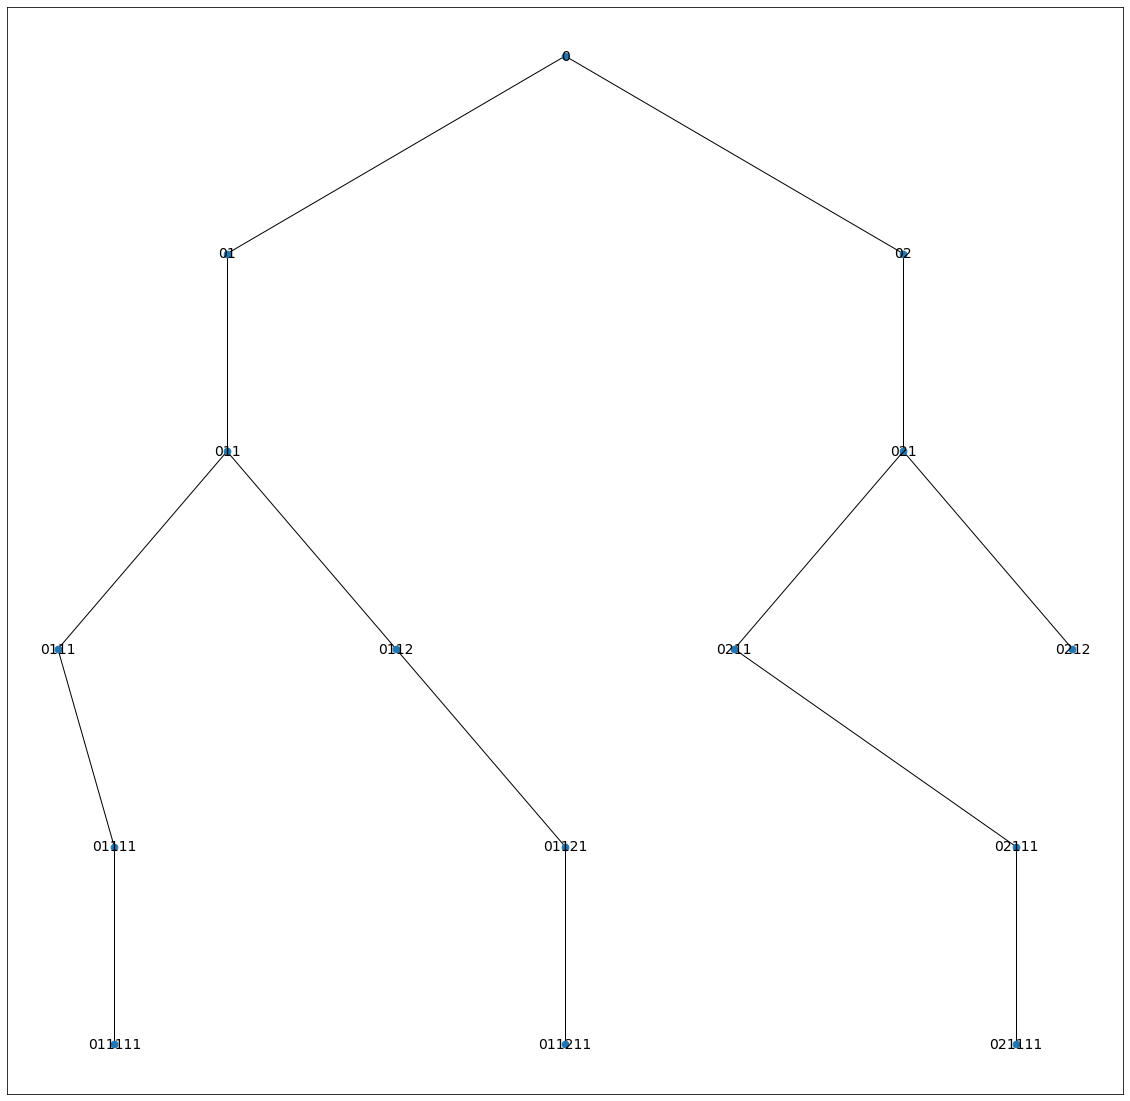

The list of heights is :
[0, 1, 2, 3, 4, 5, 3, 4, 5, 1, 2, 3, 4, 5, 3]
------------------------------------------
The list of names is :
['0', '01', '011', '0111', '01111', '011111', '0112', '01121', '011211', '02', '021', '0211', '02111', '021111', '0212']
------------------------------------------
The list of number of children is :
[2, 1, 2, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0]
------------------------------------------
The list of Luka points is :
[0, 1, 1, 2, 2, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, -1]
------------------------------------------
The list of Breadth First Search points is :
[2, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0]


In [ ]:
for i in range (10):
    galton=Galton_Watson([],0,"0")
    galton.simulate(100)
    graph=Graph(1)
    graph.add_nodes(galton)
    graph.add_edges(galton)
    if len(galton.children) >0 :
        plt.figure(3,figsize=(20,20))
        graph.draw_graph_tree(galton)
        plt.show()
    else :
        print ("================================================")
        print ("Il y a un seul noeud")
        print ("--------------------------")
    print("The list of heights is :")
    print (galton.Height_list())
    print ("------------------------------------------")
    print("The list of names is :")
    print (galton.Name_list())
    print ("------------------------------------------")
    print("The list of number of children is :")
    print (galton.Children_Number_list())
    print ("------------------------------------------")
    print("The list of Luka points is :")
    print (galton.Luka_list())
    print ("------------------------------------------")
    print("The list of Breadth First Search points is :")
    print (galton.Breadth_Search())
    
    




# Partie 2 : Simulation pour la marche de Lukasiewicz

# 2.1 
La fonction Luka_simulate prend en argument x et n et renvoie la marche de Lukasiewicz au point partie entière de (nx) divisé par racine carrée de n. L'objet de mes simulations est de déterminer si oui ou non ce que renvoie cette fonction se comporte comme une gaussienne de variance dépendant de x. Le paramètre sample_precision correspond à la précision que l'on souhaite pour notre variable aléatoire. Plus n est grand plus on a de chance d'observer une gaussienne. En effet, on veut approcher lim n -> +∞ X[nt]/sqrt(n), sample_precision correspond à ce n que l'on choisit. 

In [ ]:
def Luka_simulate(x,sample_precision, stop):
    m=floor(sample_precision*x)
    l=np.array([])
    s=0
    while len(l)<=m :
        galton=Galton_Watson([],0,"0")
        galton.simulate(stop)
        gallist=np.array(galton.Luka_list())-np.ones(len(galton.Luka_list()))*s
        l=np.concatenate((l,gallist))
        s+=1
        
        
    return (l[m]/sqrt(sample_precision),l)


# 2.2 
La fonction get_samples simule 4 échantillons de taille sample_size correspondant à 4 valeurs de x différentes.

In [ ]:
def get_samples(u,sample_size,sample_precision, stop):
    l=[]
    for i in range (len(u)):
        l.append([])
    for j in range (len(u)):
        for i in range (sample_size):
            l[j].append(Luka_simulate(u[j],sample_precision, stop)[0])
            print (j,i)
    return l

# 2.3 
J'affiche 4  histogrammes pour chacune des valeurs de x choisies. J'ai choisi sample_précision=200, sample_size=1000, et les valeurs 0.3, 0.7, 1, 1.3 pour x. Les résultats sont très concluants. On constate bien l'apparition d'une gaussienne pour chaque valeur de x, avec un écart type augmentant avec x. Pour voir les résultats, dérouler jusqu'à la fin la liste de chiffres qui me sert de compteur pour mesurer le temps qu'il reste.

In [ ]:
valeurs_t=[0.5,1,1.5]
samples=get_samples(valeurs_t,1000,3000, 3000) 

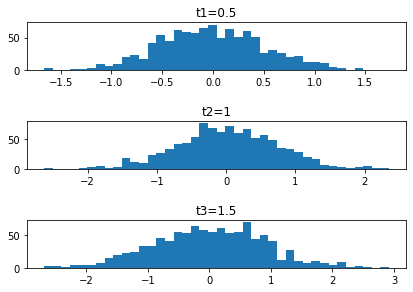

In [ ]:
a=len(samples)
fig, axs = plt.subplots(a)
fig.tight_layout(h_pad=3) 
if (a>0):
    for i in range (a):
        axs[i].hist(samples[i],bins=40 )
        axs[i].set_title('t'+str(i+1)+'='+str(valeurs_t[i]))
else :
    axs.hist(samples[0],bins=50)
    axs.set_title('t1='+str(valeurs_t[0]))

# 2.4 
La fonction Luka_Simulate_trajectories prend en entrée un vecteur x, une précision "sample_précision", et renvoie les points du vecteur x de la marche de Lukasiewicz normalisé par racine de sample_precision pour sample_precision donné. Pour x un vecteur de points très rapprochés entre 0 et 1, on obtient le comportemennt de la marche de Lukasiewicz en tant que mouvement brownien. Comme on s'interesse à des micro variations, on souhaite avoir la plus grande précision possible. J'ai donc choisi une précision de 100 000 pour mes simulations soit 100 fois supèrieures à celle choisie dans mes simulations précédentes d'un unique point. 

In [ ]:
def Luka_Simulate_trajectories(x,sample_precision):
    m=(x*sample_precision).astype(int)
    l=np.array([])
    s=0
    while len(l)<=m[-1] :
        galton=Galton_Watson([],0,"0")
        galton.simulate(100000)
        gallist=np.array(galton.Luka_list())-np.ones(len(galton.Luka_list()))*s
        l=np.concatenate((l,gallist))
        s+=1
    return ([l[i]/sqrt(sample_precision) for i in m])

# 2.5
Pour une précision "sample_precision" et un vecteur x, on plot number_trajectories trajectoires de la marche de Lukasiewicz.

In [ ]:
def plot_brownian_Luka(sample_precision, number_trajectories,x):
    fig, ax = plt.subplots(figsize=(15,15))
    for i in range(number_trajectories):
        y=Luka_Simulate_trajectories(x,sample_precision)
        ax.plot(x, y,label='trajectoire '+str(i+1))
        ax.set(xlabel='valeurs de t', ylabel='lim n-> +∞, X[n*t]/sqrt(n), infini approché par '+str(sample_precision))
    ax.grid()
    ax.legend()
    plt.show()

# 2.6
On affiche 6 trajectoires pour x un vecteur de 1000 pas entre 0 et 1 et une précision de 100 000.

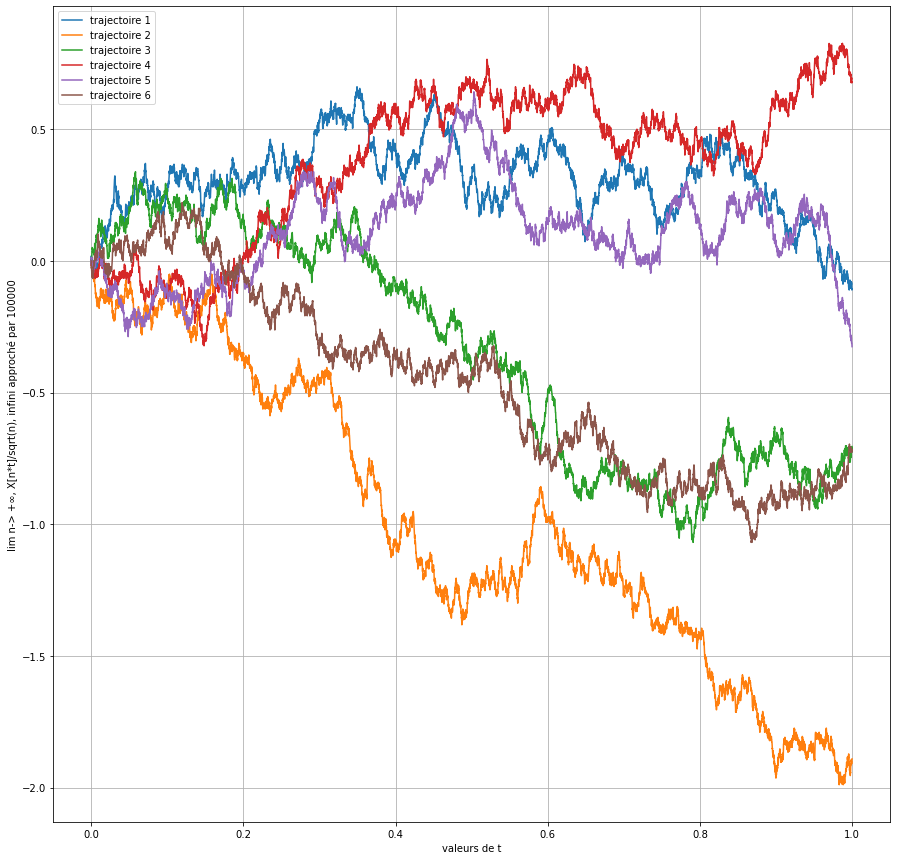

In [ ]:
x=np.arange(0,1,0.0001)
plot_brownian_Luka(100000,6,x)

# PARTIE 3 : Simulations pour la marche Breadth Search
Cette partie fait exactement la même chose que la partie précédente, je copie juste le nom des sous-parties correspondantes.

# 3.1 / 3.2

In [ ]:
def Breadth_First_simulate(x,n, stop):
    m=floor(n*x)
    l=np.array([])
    s=0
    while len(l)<=m :
        galton=Galton_Watson([],0,"0")
        galton.simulate(stop)
        gallist=np.array(galton.Breadth_Search_List())-np.ones(len(galton.Breadth_Search_List()))*s
        l=np.concatenate((l,gallist))
        s+=1
    return (l[m]/sqrt(n),l)

def Breadth_First_get_samples(u,sample_size,sample_precision, stop):
    l=[]
    for i in range (len(u)):
        l.append([])
    for j in range (len(u)):
        for i in range (sample_size):
            l[j].append(Breadth_First_simulate(u[j],sample_precision, stop)[0])
            print (j,i)
    return l

# 3.3

In [ ]:
valeurs_breadth_t=[0.8,1.2]
samples_breath=Breadth_First_get_samples(valeurs_breadth_t,1000,2000, 1000)

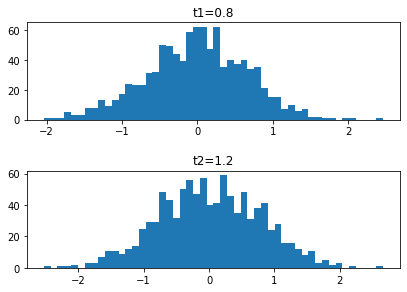

In [ ]:
b=len(samples_breath)
fig, axs = plt.subplots(b)
fig.tight_layout(h_pad=3) 
if (b>0):
    for i in range (b):
        axs[i].hist(samples_breath[i],bins=50 )
        axs[i].set_title('t'+str(i+1)+'='+str(valeurs_breadth_t[i]))
else :
    axs.hist(samples_breath[0],bins=50)
    axs.set_title('t1='+str(valeurs_breadth_t[0]))


# 3.4 / 3.5

In [ ]:
def Breadth_Search_Simulate_trajectories(x,sample_precision):
    m=(x*sample_precision).astype(int)
    l=np.array([])
    s=0
    while len(l)<=m[-1] :
        galton=Galton_Watson([],0,"0")
        galton.simulate(100000)
        gallist=np.array(galton.Breadth_Search_List())-np.ones(len(galton.Breadth_Search_List()))*s
        l=np.concatenate((l,gallist))
        s+=1
    
    return ([l[i]/sqrt(sample_precision) for i in m])
def plot_brownian_Breadth_Search(sample_precision, number_trajectories,x):
    fig, ax = plt.subplots(figsize=(15,15))
    for i in range(number_trajectories):
        y=Breadth_Search_Simulate_trajectories(x,sample_precision)
        ax.plot(x, y,label='trajectoire '+str(i+1))
        ax.set(xlabel='valeurs de t', ylabel='lim n-> +∞, B[n*t]/sqrt(n), infini approché par '+str(sample_precision))
    ax.grid()
    ax.legend()
    plt.show()

# 3.6

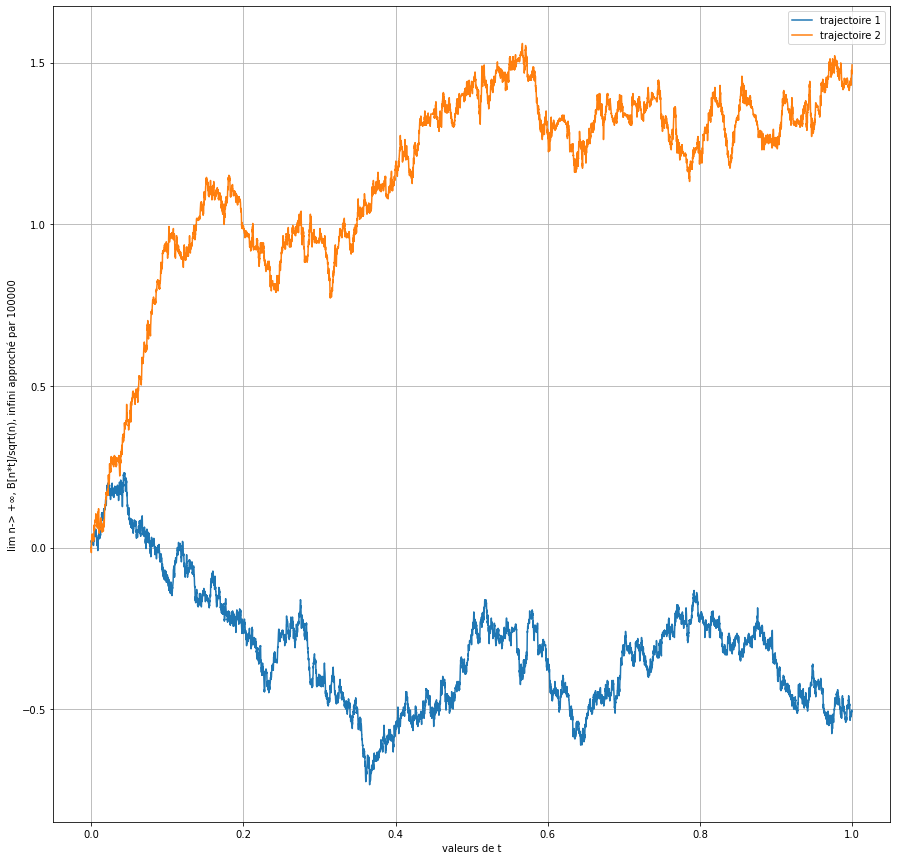

In [ ]:
x=np.arange(0,1,0.0001)
plot_brownian_Breadth_Search(100000,2,x)

# Partie 4 : Tests statistiques

## 4.1 Tests statistiques pour Lukasiewicz avec précision 3000

In [ ]:
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
data_luka = samples

luka_shapiro_list=[]
luka_agostino_list=[]
luka_anderson_list=[]
for i in range (len(data_luka)):
    temp=data_luka[i]
    luka_shapiro_list.append(shapiro(temp))
    luka_agostino_list.append(normaltest(temp))
    luka_anderson_list.append(anderson(temp))
    stat_luka_shapiro,p_luka_shapiro=luka_shapiro_list[i]
    stat_luka_agostino, p_luka_agostino=luka_agostino_list[i]
    stat_luka_anderson =luka_anderson_list[i]
    print ("==================================================================================")
    print ("Marche de Luka : résultats de trois différents tests pour la valeur "+str(valeurs_t[i]))
    print ("==================================================================================")
    print('stat_luka_shapiro=%.3f, p_luka_shapiro=%.3f' % (stat_luka_shapiro, p_luka_shapiro))
    if p_luka_shapiro > 0.05:
        print('Probably Gaussian according to Shapiro test')
    else:
        print('Probably not Gaussian according to Shapiro test')
    print ("-------------------------------------------------------------------")
    print('stat_luka_agostino=%.3f, p_luka_agostino=%.3f' % (stat_luka_agostino, p_luka_agostino))
    if p_luka_agostino > 0.05:
        print('Probably Gaussian according to Agostino test')
    else:
        print('Probably not Gaussian according to Agostino test')
    print ("-------------------------------------------------------------------")
    print('stat=%.3f' % (stat_luka_anderson.statistic))
    for i in range(len(stat_luka_anderson.critical_values)):
        sl, cv = stat_luka_anderson.significance_level[i], stat_luka_anderson.critical_values[i]
        if stat_luka_anderson.statistic < cv:
            print('Probably Gaussian at the %.1f%% level' % (sl))
        else:
            print('Probably not Gaussian at the %.1f%% level' % (sl))
          

Marche de Luka : résultats de trois différents tests pour la valeur 0.5
stat_luka_shapiro=0.998, p_luka_shapiro=0.352
Probably Gaussian according to Shapiro test
-------------------------------------------------------------------
stat_luka_agostino=0.607, p_luka_agostino=0.738
Probably Gaussian according to Agostino test
-------------------------------------------------------------------
stat=0.535
Probably Gaussian at the 15.0% level
Probably Gaussian at the 10.0% level
Probably Gaussian at the 5.0% level
Probably Gaussian at the 2.5% level
Probably Gaussian at the 1.0% level
Marche de Luka : résultats de trois différents tests pour la valeur 1
stat_luka_shapiro=0.998, p_luka_shapiro=0.286
Probably Gaussian according to Shapiro test
-------------------------------------------------------------------
stat_luka_agostino=3.039, p_luka_agostino=0.219
Probably Gaussian according to Agostino test
-------------------------------------------------------------------
stat=0.341
Probably Gaussia

## 4.2 Tests statistiques pour breadth Search avec précision 1000

In [ ]:
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
data_breadth = samples_breath

breadth_shapiro_list=[]
breadth_agostino_list=[]
breadth_anderson_list=[]
for i in range (len(data_breadth)):
    temp=data_breadth[i]
    breadth_shapiro_list.append(shapiro(temp))
    breadth_agostino_list.append(normaltest(temp))
    breadth_anderson_list.append(anderson(temp))
    stat_breadth_shapiro,p_breadth_shapiro=breadth_shapiro_list[i]
    stat_breadth_agostino, p_breadth_agostino=breadth_agostino_list[i]
    stat_breadth_anderson =breadth_anderson_list[i]
    print ("==================================================================================")
    print ("Marche Breadth_Search : résultats de trois différents tests pour la valeur "+str(valeurs_breadth_t[i]))
    print ("==================================================================================")
    print('stat_breadth_shapiro=%.3f, p_breadth_shapiro=%.3f' % (stat_breadth_shapiro, p_breadth_shapiro))
    if p_breadth_shapiro > 0.05:
        print('Probably Gaussian according to Shapiro test')
    else:
        print('Probably not Gaussian according to Shapiro test')
    print ("-------------------------------------------------------------------")
    print('stat_breadth_agostino=%.3f, p_breadth_agostino=%.3f' % (stat_breadth_agostino, p_breadth_agostino))
    if p_breadth_agostino > 0.05:
        print('Probably Gaussian according to Agostino test')
    else:
        print('Probably not Gaussian according to Agostino test')
    print ("-------------------------------------------------------------------")
    print('stat=%.3f' % (stat_breadth_anderson.statistic))
    for i in range(len(stat_breadth_anderson.critical_values)):
        sl, cv = stat_breadth_anderson.significance_level[i], stat_breadth_anderson.critical_values[i]
        if stat_breadth_anderson.statistic < cv:
            print('Probably Gaussian at the %.1f%% level' % (sl))
        else:
            print('Probably not Gaussian at the %.1f%% level' % (sl))
          

Marche Breadth_Search : résultats de trois différents tests pour la valeur 0.8
stat_breadth_shapiro=0.998, p_breadth_shapiro=0.369
Probably Gaussian according to Shapiro test
-------------------------------------------------------------------
stat_breadth_agostino=0.970, p_breadth_agostino=0.616
Probably Gaussian according to Agostino test
-------------------------------------------------------------------
stat=0.505
Probably Gaussian at the 15.0% level
Probably Gaussian at the 10.0% level
Probably Gaussian at the 5.0% level
Probably Gaussian at the 2.5% level
Probably Gaussian at the 1.0% level
Marche Breadth_Search : résultats de trois différents tests pour la valeur 1.2
stat_breadth_shapiro=0.999, p_breadth_shapiro=0.649
Probably Gaussian according to Shapiro test
-------------------------------------------------------------------
stat_breadth_agostino=1.786, p_breadth_agostino=0.409
Probably Gaussian according to Agostino test
-------------------------------------------------------